In [1]:
import math
import hess
import matplotlib.pyplot as plt
import numpy as np
from hess.nets import SubLayerLinear, SubNetLinear, MaskedNetLinear
import hess.net_utils as net_utils
import hess.utils as utils
import torch
from torch import nn

In [2]:
def twospirals(n_points, noise=.5, random_state=920):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 600 * (2*np.pi)/360
    d1x = -1.5*np.cos(n)*n + np.random.randn(n_points,1) * noise
    d1y =  1.5*np.sin(n)*n + np.random.randn(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [3]:
X, Y = twospirals(500, noise=1.3)
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y).unsqueeze(-1)

In [4]:
n_hidden = 5
width = 1024

In [5]:
subnet_model = SubNetLinear(in_dim=2, out_dim=1, n_layers=n_hidden, k=width, bias=False)
masked_model = MaskedNetLinear(in_dim=2, out_dim=1, n_layers=n_hidden, k=width, bias=False)

In [6]:
hess.net_utils.set_model_prune_rate(subnet_model, 0.5)
hess.net_utils.freeze_model_weights(subnet_model)

weights = net_utils.get_weights_from_subnet(subnet_model)

net_utils.apply_weights(masked_model, weights)
mask = net_utils.get_mask_from_subnet(subnet_model)
net_utils.apply_mask(masked_model, mask)
mask = utils.flatten(mask)

==> Setting prune rate of network to 0.5
==> Setting prune rate of sequential.0 to 0.5
==> Setting prune rate of sequential.2 to 0.5
==> Setting prune rate of sequential.4 to 0.5
==> Setting prune rate of sequential.6 to 0.5
==> Setting prune rate of sequential.8 to 0.5
==> Setting prune rate of sequential.10 to 0.5
==> Setting prune rate of sequential.12 to 0.5
=> Freezing model weights
==> No gradient to sequential.0.weight
==> No gradient to sequential.2.weight
==> No gradient to sequential.4.weight
==> No gradient to sequential.6.weight
==> No gradient to sequential.8.weight
==> No gradient to sequential.10.weight
==> No gradient to sequential.12.weight
==> Applied Weights
==> Applied Mask


In [7]:
loss_func = torch.nn.BCEWithLogitsLoss()

In [8]:
%pdb

Automatic pdb calling has been turned ON


In [9]:
eigs = utils.get_hessian_eigs(loss_func, masked_model, mask=mask, n_eigs=100,
                             train_x=train_x, train_y=train_y)

numpars is:  2622976
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
finished a hvp
fini

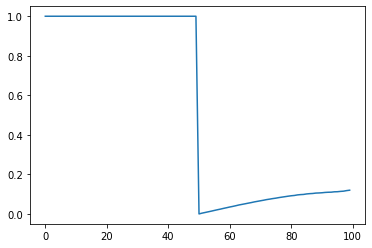

In [10]:
plt.plot(eigs)